Реализуйте Robust-PCA устойчивый к шуму (позволяющий восстанавливать низкоранговые матрицы даже при наличие большого шума) из статьи "Robust Principal Component Analysis" (выложено на диск - прочитайте и осознайте в чем отличие от обычного PCA!) и покажите, что ваша реализация работает.

Указания:

Рекомендуемый авторами алгоритм обучения представлен в секции 5
Проверку можно провести как в секции 4.1

In [1]:
import numpy as np
from scipy.linalg import svd
from numpy.linalg import norm

In [5]:
def prox_nuclear_norm(M, tau):
    U, Sigma, Vt = np.linalg.svd(M, full_matrices=False)  # SVD разложение M
    Sigma_thresh = np.maximum(Sigma - tau, 0)  # обрезаем сингулярные значения
    return np.dot(U, np.dot(np.diag(Sigma_thresh), Vt))  # восстанавливаем матрицу с новыми сингулярными значениями


In [11]:
def prox_l1_norm(M, tau):
    return np.sign(M) * np.maximum(np.abs(M) - tau, 0)  # Обрезаем все элементы, которые меньше tau по абсолютной величине

In [42]:
def robust_pca(M, L0, S0, lambda_val_L=0.01, lambda_val_S=0.001, mu=1e-3, max_iter=500, tol=1e-4, adapt_mu=True):
    # Инициализация переменных
    L = np.zeros_like(M)  # низкоранговая матрица L
    S = np.zeros_like(M)  # инициализируем шум
    Y = np.zeros_like(M)  # множитель Лагранжа для контроля условия M = L + S

    for iteration in range(max_iter):
        # обновляем L на каждой итерации цикла
        L = prox_nuclear_norm(M - S + Y / mu, lambda_val_L / mu)
        # обновляем S на каждой итерации цикла
        S = prox_l1_norm(M - L + Y / mu, lambda_val_S / mu)
        Y = Y + mu * (M - L - S)  # для коррекции

        # если динамически изменять мю, то результат получается лучше
        if adapt_mu:
            mu = min(mu * 1.02, 1e2)
        # если ошибка маленькая, выходим из цикла
        error_L = norm(L - L0, 'fro') / norm(L0, 'fro')
        error_S = norm(S - S0, 'fro') / norm(S0, 'fro')
    return L, S

In [43]:
# генерируем случайные данные для тестирования
def generate_data(n, r, k, noise_level=0.03):
    # генерируем низкоранговую матрицу L0
    X = np.random.randn(n, r) / np.sqrt(n) # случайнаяя матрица X (n x r)
    Y = np.random.randn(n, r) / np.sqrt(n) # случайнаяя матрица Y (n x r)
    L0 = np.dot(X, Y.T)  # низкоранговая матрица L0 (произведение матриц X и Y.T)

    # генерируем шум
    S0 = np.zeros_like(L0)  # сначала шум = 0
    idx = np.random.choice(n * n, size=k, replace=False)  # индексы для выбросов
    S0.flat[idx] = np.random.randn(k) * noise_level  # добавляем случайные выбросы

    # добавляем случайный шум
    S0 += np.random.randn(*S0.shape) * noise_level * 0.5

    M = L0 + S0  # M = L0 + S0 (сумма низкоранговой части и шума)
    return M, L0, S0

In [44]:
# проверяем как в разделе 4.1
n = 500  # размерность
r = int(0.05 * n)  # ранг
k = int(0.01 * n**2)  # кол-во выбросов
noise_level = 0.03  # уровень шума
M, L0, S0 = generate_data(n, r, k, noise_level)

lambda_val_L = 0.05  # параметр регуляризации для L
lambda_val_S = 0.005  # уменьшила, чтобы увеличить точность (помогло)
L, S = robust_pca(M, L0, S0, lambda_val_L=lambda_val_L, lambda_val_S=lambda_val_S, mu=1e-3, max_iter=1000, tol=1e-9, adapt_mu=True)

# проверяем ошибку восстановления
error_L = norm(L - L0, 'fro') / norm(L0, 'fro')
error_S = norm(S - S0, 'fro') / norm(S0, 'fro')

print(f"Ошибка восстановления L: {error_L:.6f}")
print(f"Ошибка восстановления S: {error_S:.6f}")


Ошибка восстановления L: 0.000316
Ошибка восстановления S: 0.000927


Дополнительно: повторите эксперименты из пунктов 4.3 и 4.4 (возможно со своими данными) или придумайте (возьмите из сторонних источников) какое-то другое приложение и продемонстрируйте

success


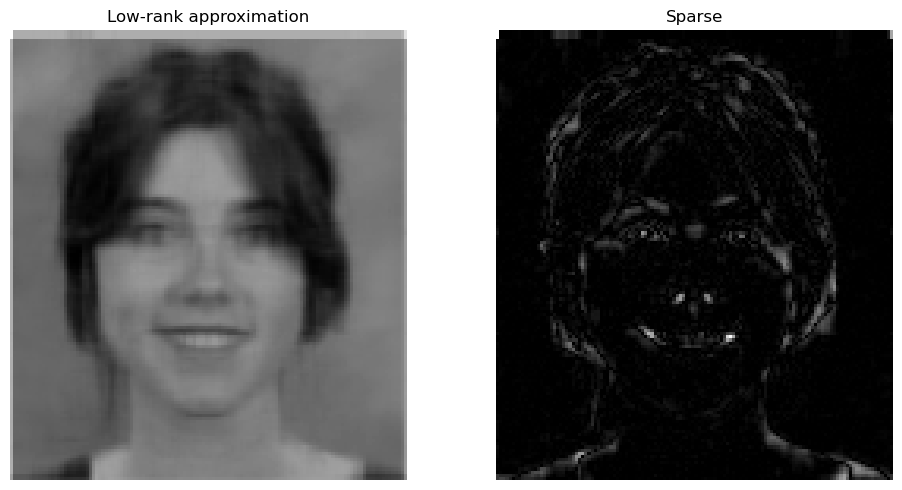

In [50]:
import cv2
import matplotlib.pyplot as plt

# загружаем изображение с лицом
image = cv2.imread('photo/face_image2.png', cv2.IMREAD_GRAYSCALE)

# уменьшим размер изображения для тестирования
image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2))

# делим изображение на низкоранговую часть (освещенность) и разреженную (тени и блики)
L, S = robust_pca(image, L0=image, S0=image, lambda_val_L=0.07, lambda_val_S=0.005, mu=1e-3, max_iter=500, tol=1e-4, adapt_mu=True)
S = np.abs(S)
S_normalized = cv2.normalize(S, None, 0, 255, cv2.NORM_MINMAX)

# сохраним результаты
cv2.imwrite('photo/low_rank.jpg', L)
cv2.imwrite('photo/sparse.jpg', S)
print('success')

# визуализируем результаты с помощью matplotlib
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# низкоранговая аппроксимация
axes[0].imshow(L, cmap='gray')
axes[0].set_title("Low-rank approximation")
axes[0].axis('off')

# ошибка разреженности
axes[1].imshow(S, cmap='gray')
axes[1].set_title("Sparse")
axes[1].axis('off')

# Показываем изображения
plt.tight_layout()
plt.show()

Видно, что sparse матрица содержит тени, которые отбрасываются в low rank approximation.

Теперь посмотрим на фрагменты из видео

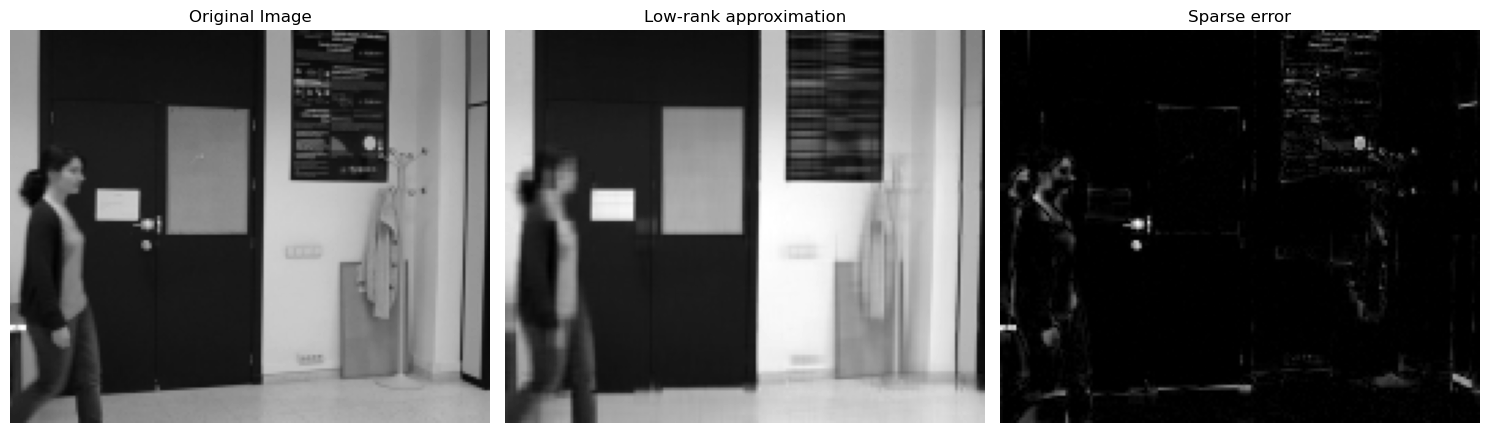

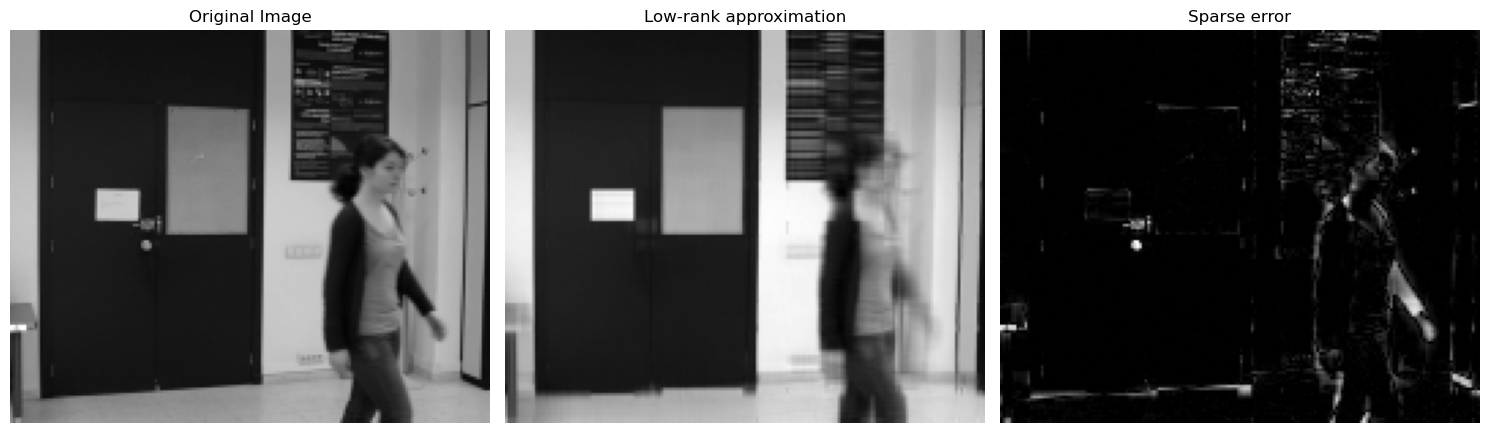

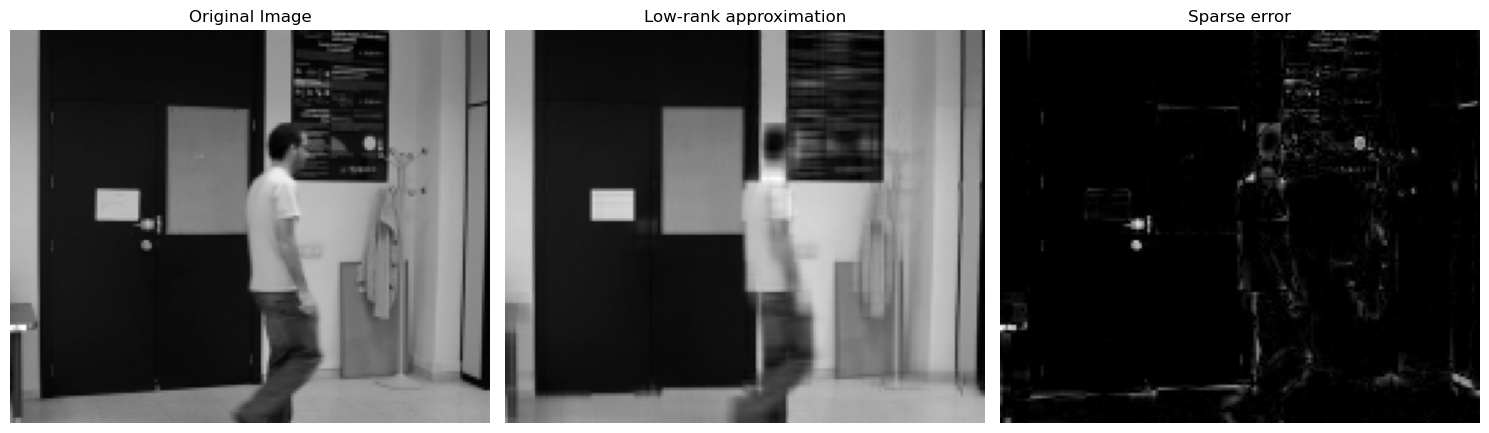

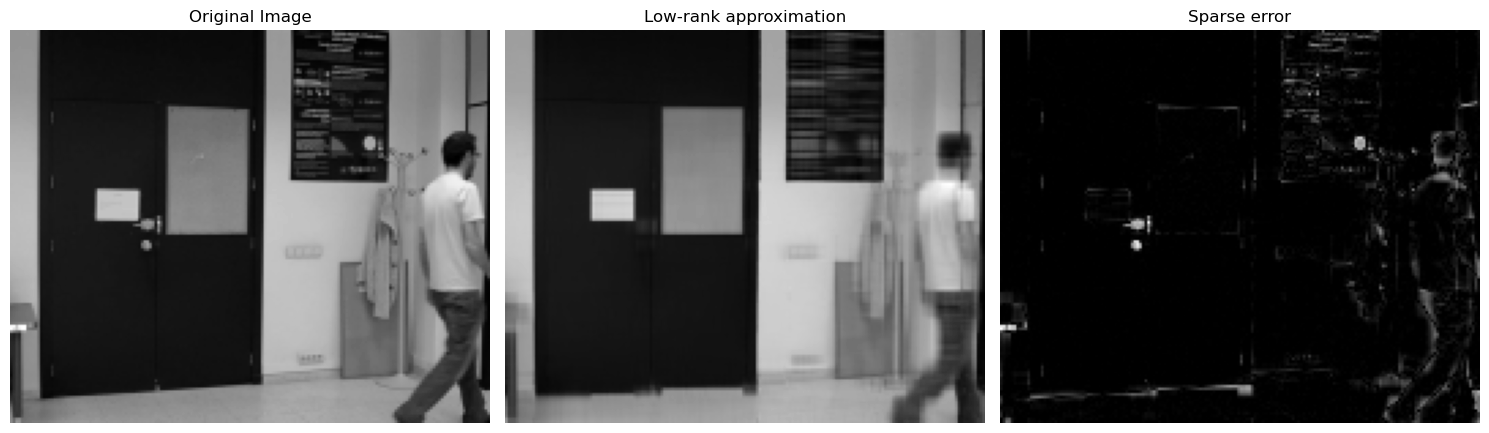

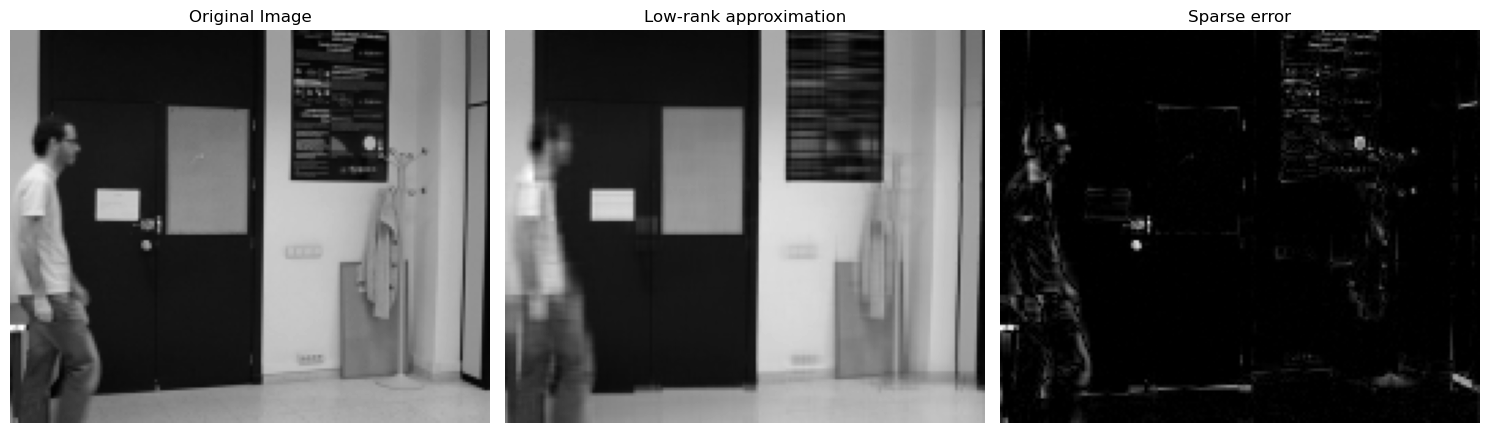

In [51]:
from pathlib import Path

folder_path = 'video'

for img_path in Path(folder_path).iterdir():
    if img_path.is_file():
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

        # проверим, что все успешно выгрузилось
        if image is None:
            print(f"Не удалось загрузить изображение: {img_path}")
            continue

        # уменьшим размер
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2))

        # делим изображение на низкоранговую и разреженную части
        L, S = robust_pca(image, L0=image, S0=image, lambda_val_L=0.07, lambda_val_S=0.005, mu=1e-3, max_iter=500, tol=1e-4, adapt_mu=True)

        S = np.abs(S)

        # масштабируем S в диапазон [0, 255] для визуализации
        S_normalized = cv2.normalize(S, None, 0, 255, cv2.NORM_MINMAX)

        # визуализация
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # оригинал
        axes[0].imshow(image, cmap='gray')
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        # низкоранговая аппроксимация
        axes[1].imshow(L, cmap='gray')
        axes[1].set_title("Low-rank approximation")
        axes[1].axis('off')

        # визуализация ошибки разреженности
        axes[2].imshow(S_normalized, cmap='gray')
        axes[2].set_title("Sparse error")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()




Итого low rank матрица хорошо понимает, где основное освещение + фон, а sparse матрица - определяет движение + фигуру человека
